## Experiment management
### Problem statement
Predict whether the market for BTC(bitcoin ticker)/USD will go up or not in a single day.
- Success and failure: success is defined as the highest performance metric of the F score.
- Model output: `1` for an increase in value of a stock ticker, `0` for non-increase.
- Output usage:  used to provide a rest API with true or false values.
- Data
    - Input: Historical end of the day's price of a given ticker for the last 10 days.
    - Output: `1` for increasing, `0` for not increasing

In [1]:
import datetime

import mlflow
import pandas as pd
import numpy as np
import pandas_datareader.data as web

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split

import xgboost as xgb

## Retrieve dataset

In [2]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 12, 31)

In [3]:
btc_df = web.DataReader("BTC-USD", "yahoo", start, end)
btc_df['delta_pct'] = (btc_df['Close'] - btc_df['Open']) / btc_df['Open']

# target variable
btc_df['going_up'] = btc_df['delta_pct'].apply(lambda d: 1 if d > 0.00001 else 0).to_numpy()

In [4]:
btc_df.head()

High         Low        Open       Close    Volume  \
Date                                                                   
2014-09-17  468.174011  452.421997  465.864014  457.334015  21056800   
2014-09-18  456.859985  413.104004  456.859985  424.440002  34483200   
2014-09-19  427.834991  384.532013  424.102997  394.795990  37919700   
2014-09-20  423.295990  389.882996  394.673004  408.903992  36863600   
2014-09-21  412.425995  393.181000  408.084991  398.821014  26580100   

             Adj Close  delta_pct  going_up  
Date                                         
2014-09-17  457.334015  -0.018310         0  
2014-09-18  424.440002  -0.070963         0  
2014-09-19  394.795990  -0.069104         0  
2014-09-20  408.903992   0.036058         1  
2014-09-21  398.821014  -0.022701         0

In [5]:
btc_df.tail()

High           Low          Open         Close  \
Date                                                                 
2020-12-28  27389.111328  26207.640625  26280.822266  27084.808594   
2020-12-29  27370.720703  25987.298828  27081.810547  27362.437500   
2020-12-30  28937.740234  27360.089844  27360.089844  28840.953125   
2020-12-31  29244.876953  28201.992188  28841.574219  29001.720703   
2021-01-01  29600.626953  28803.585938  28994.009766  29374.152344   

                 Volume     Adj Close  delta_pct  going_up  
Date                                                        
2020-12-28  49056742893  27084.808594   0.030592         1  
2020-12-29  45265946774  27362.437500   0.010362         1  
2020-12-30  51287442704  28840.953125   0.054125         1  
2020-12-31  46754964848  29001.720703   0.005553         1  
2021-01-01  40730301359  29374.152344   0.013111         1

In [6]:
btc_df.shape

(2299, 8)

<AxesSubplot: xlabel='Date'>

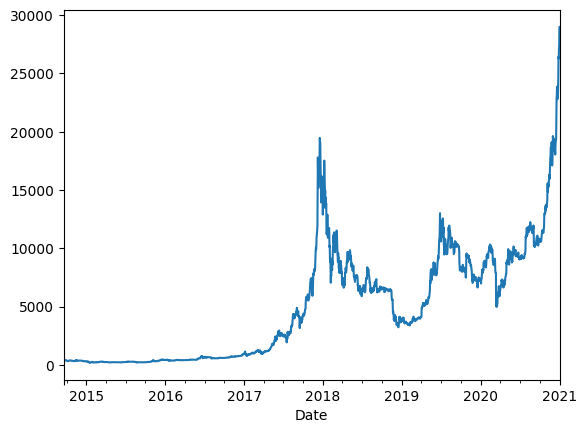

In [7]:
btc_df["Open"].plot()

In [8]:
def rolling_window(a, window):
    """
        Takes np.array 'a' and size 'window' as parameters
        Outputs an np.array with all the ordered sequences of values of 'a' of size 'window'
        e.g. Input: ( np.array([1, 2, 3, 4, 5, 6]), 4 )
             Output: 
                     array([[1, 2, 3, 4],
                           [2, 3, 4, 5],
                           [3, 4, 5, 6]])
    """
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


In [9]:
element = btc_df['going_up'].to_numpy()

In [10]:
WINDOW_SIZE=15
training_data = rolling_window(element, WINDOW_SIZE)

In [11]:
training_data.shape

(2285, 15)

In [12]:
X = training_data[:, :-1]
y = training_data[:, -1]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1234, stratify=y)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1530, 14) (1530,)
(755, 14) (755,)


## Logistic regression (baseline)

In [15]:
mlflow.set_experiment("Baseline_Predictions")
mlflow.sklearn.autolog()
with mlflow.start_run(run_name='logistic_regression_model_baseline') as run:
    # build & train model
    model = LogisticRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    # log metrics
    y_pred = np.where(preds>0.5,1,0)
    f1 = f1_score(y_test, y_pred)
    mlflow.log_metric(key="f1_experiment_score", value=f1)

2022/09/18 14:20:32 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/conda/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


## XGboost-based classifier

In [16]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

threshold = 0.5

In [ ]:
mlflow.set_experiment("Baseline_Predictions")
mlflow.xgboost.autolog()
with mlflow.start_run(run_name='xgboost_model_baseline') as run:
    # build & train model
    model = xgb.train(dtrain=dtrain, params={})
    preds = model.predict(dtest)
    y_bin = [1. if y_cont > threshold else 0. for y_cont in preds]
    
    # log metrics
    f1= f1_score(y_test,y_bin)
    mlflow.log_metric(key="f1_experiment_score", value=f1)

2022/09/18 14:20:32 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2022/09/18 14:20:32 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.


## Deep-learning based classifier

In [64]:
import tensorflow
from tensorflow import keras
import mlflow.keras

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates